In [1]:
%run 0_3_configure_mlflow.ipynb

Experiment_id: 1
Artifact Location: file:///E:/Studia/Inzynierka/csgo-analysis/notebooks/mlruns/1
Tags: {}
Lifecycle_stage: active


In [2]:
import pandas as pd
import lightgbm as lgbm
import numpy as np
import matplotlib.pyplot as plt
import pickle
import shap
import os

from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss, f1_score, RocCurveDisplay, roc_auc_score
from sklearn.calibration import CalibrationDisplay
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import StratifiedKFold

# Wczytanie danych

In [3]:
df = pd.read_parquet('data/states_another_mod.parquet')
df

,filename,mapName,ctBuyType,tBuyType,winningSide,matchID,roundNum,seconds,ctAlivePlayers,ctEqVal,...,de_ancient,de_dust2,de_inferno,de_mirage,de_nuke,de_overpass,de_vertigo,bombsite_A,bombsite_B,bombsite_not_planted
0,BLAST-Premier-Spring-Final-2022-ence-vs-big-bo...,de_mirage,Full Eco,Full Eco,CT,1,1,0.148438,5,3700,...,0,0,0,1,0,0,0,0,0,1
1,BLAST-Premier-Spring-Final-2022-ence-vs-big-bo...,de_mirage,Full Eco,Full Eco,CT,1,1,0.398438,5,3700,...,0,0,0,1,0,0,0,0,0,1
2,BLAST-Premier-Spring-Final-2022-ence-vs-big-bo...,de_mirage,Full Eco,Full Eco,CT,1,1,0.648438,5,3700,...,0,0,0,1,0,0,0,0,0,1
3,BLAST-Premier-Spring-Final-2022-ence-vs-big-bo...,de_mirage,Full Eco,Full Eco,CT,1,1,0.898438,5,3700,...,0,0,0,1,0,0,0,0,0,1
4,BLAST-Premier-Spring-Final-2022-ence-vs-big-bo...,de_mirage,Full Eco,Full Eco,CT,1,1,1.148438,5,3700,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3186232,PGL-Major-Antwerp-2022-vitality-vs-outsiders-m...,de_mirage,Full Buy,Semi Buy,CT,333,24,19.765625,1,30150,...,0,0,0,1,0,0,0,1,0,0
3186233,PGL-Major-Antwerp-2022-vitality-vs-outsiders-m...,de_mirage,Full Buy,Semi Buy,CT,333,24,20.015625,1,30150,...,0,0,0,1,0,0,0,1,0,0
3186234,PGL-Major-Antwerp-2022-vitality-vs-outsiders-m...,de_mirage,Full Buy,Semi Buy,CT,333,24,20.265625,1,30150,...,0,0,0,1,0,0,0,1,0,0
3186235,PGL-Major-Antwerp-2022-vitality-vs-outsiders-m...,de_mirage,Full Buy,Semi Buy,CT,333,24,20.515625,1,30150,...,0,0,0,1,0,0,0,1,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3186237 entries, 0 to 3186236
Columns: 108 entries, filename to bombsite_not_planted
dtypes: float64(17), int32(7), int64(68), object(6), uint8(10)
memory usage: 2.3+ GB


## Podział

In [5]:
df.columns.values

array(['filename', 'mapName', 'ctBuyType', 'tBuyType', 'winningSide',
       'matchID', 'roundNum', 'seconds', 'ctAlivePlayers', 'ctEqVal',
       'tAlivePlayers', 'tEqVal', 'bombsite', 'ct_hp', 't_hp', 'ct_armor',
       't_armor', 'ct_hasHelmet', 't_hasHelmet', 'ct_DecoyGrenade',
       't_DecoyGrenade', 'ct_Flashbang', 't_Flashbang', 'ct_HEGrenade',
       't_HEGrenade', 'ct_SmokeGrenade', 't_SmokeGrenade',
       'ct_fireGrenades', 't_fireGrenades', 'ct_isBlinded', 't_isBlinded',
       'ct_hasDefuse', 't_hasBomb', 'ct_isDefusing', 't_isPlanting',
       'tScore', 'ctScore', 'ct_meanDist', 'ct_minDist', 't_meanDist',
       't_minDist', 'ct_spottedPlayers', 't_spottedPlayers',
       'ct_grouppedPlayers', 't_grouppedPlayers', 'ct_conquerMap',
       't_conquerMap', 'ct_activeWeapon_Pistol',
       'ct_activeWeapon_EnhancedPistols', 'ct_activeWeapon_Deagle',
       'ct_activeWeapon_SMG', 'ct_activeWeapon_WeakAssaultRifle',
       'ct_activeWeapon_LunetRifle', 'ct_activeWeapon_Sniper

In [6]:
def select_feat(prep_df):
    columns = ['t_activeWeapon_LunetRifle', 't_hasHelmet', 'de_dust2', 'ct_activeWeapon_SMG', 't_grouppedPlayers', 'ct_secondaryWeapon_Deagle', 
               'ct_mainWeapon_EnhancedPistols', 'ct_hasHelmet', 't_meanDist', 'ct_SmokeGrenade', 'ctMeanKills', 't_mainWeapon_AssaultRifle', 
               't_conquerMap', 'ct_HEGrenade', 
               'ctAlivePlayers', 'ctMinDistToB', 't_hp', 't_hasBomb', 'ct_spottedPlayers', 't_activeWeapon_WeakAssaultRifle', 'ct_mainWeapon_Pistol', 
               'ct_activeWeapon_AssaultRifle', 'tMinDistToB', 'de_mirage', 't_isPlanting', 'ctMeanDistToB', 'ct_secondaryWeapon_EnhancedPistols', 
               't_secondaryWeapon_Deagle', 
               'tMinDistToA', 't_mainWeapon_LunetRifle', 'ct_mainWeapon_Deagle', 'bombsite_B', 't_mainWeapon_Pistol', 't_mainWeapon_WeakAssaultRifle', 
               'bombsite_A', 'ctMinDistToA', 'bombsite_not_planted', 'ct_meanDist', 'tScore', 'ct_activeWeapon_WeakAssaultRifle', 'ct_conquerMap', 
               'ct_fireGrenades', 't_Flashbang', 't_activeWeapon_SniperRifle', 't_activeWeapon_Deagle', 'tMeanKills', 't_mainWeapon_SniperRifle', 
               'ct_armor', 'ct_hp', 'ct_Flashbang', 'ct_mainWeapon_WeakAssaultRifle', 'de_overpass', 'de_ancient', 'ctMeanDistToA', 'de_inferno', 
               't_mainWeapon_SMG', 'tMeanDistToA', 'de_vertigo', 'tAlivePlayers', 't_activeWeapon_EnhancedPistols', 't_HEGrenade', 'ct_mainWeapon_LunetRifle',
               'ct_isDefusing', 't_armor', 'ct_activeWeapon_Deagle', 'ct_minDist', 't_fireGrenades', 'ctScore', 'tEqVal', 
               'ct_DecoyGrenade', 'ctEqVal', 'seconds', 'ct_hasDefuse', 'ct_mainWeapon_SniperRifle', 'ct_mainWeapon_SMG', 't_SmokeGrenade',
               't_mainWeapon_Deagle', 'ct_secondaryWeapon_Pistol', 'tMeanDistToB', 't_DecoyGrenade', 'de_nuke', 't_secondaryWeapon_EnhancedPistols', 
               'ct_mainWeapon_AssaultRifle', 't_minDist', 't_secondaryWeapon_Pistol']
    return prep_df[columns]

In [7]:
X = select_feat(df)
y = df['winningSideCT']
X.shape, y.shape

((3186237, 85), (3186237,))

In [8]:
y.value_counts()

1    1658611
0    1527626
Name: winningSideCT, dtype: int64

In [9]:
filtr = df.filename.str.startswith('BLAST-Premier-Spring-Final-2022')
X_train, X_test, y_train, y_test = X.loc[~filtr], X.loc[filtr], y[~filtr], y[filtr]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2886886, 85), (299351, 85), (2886886,), (299351,))

In [10]:
y_train.value_counts(normalize=True)

1    0.523845
0    0.476155
Name: winningSideCT, dtype: float64

In [11]:
y_test.value_counts(normalize=True)

0    0.511179
1    0.488821
Name: winningSideCT, dtype: float64

In [12]:
parameters = {
    "num_leaves": Integer(4, 70),
    "max_depth": Integer(2, 80),
    "n_estimators": Integer(100, 1300),
    "subsample": Real(0.6, 1),
    "subsample_freq": Integer(0, 2)
}

opt = BayesSearchCV(lgbm.LGBMClassifier(n_jobs=4),
                    search_spaces=parameters,
                    scoring="neg_log_loss",
                    n_iter=50,
                    n_jobs=1, 
                    cv=StratifiedKFold(n_splits=3),
                    verbose=1,
                    random_state=42)
opt.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

BayesSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
              estimator=LGBMClassifier(n_jobs=4), random_state=42,
              scoring='neg_log_loss',
              search_spaces={'max_depth': Integer(low=2, high=80, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=100, high=1300, prior='uniform', transform='normalize'),
                             'num_leaves': Integer(low=4, high=70, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.6, high=1, prior='uniform', transform='normalize'),
                             'subsample_freq': Integer(low=0, high=2, prior='uniform', transform='normalize')},
              verbose=1)

In [13]:
model_lgbm = opt.best_estimator_
res = pd.DataFrame(opt.cv_results_)
res.sort_values(by="mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,param_num_leaves,param_subsample,param_subsample_freq,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
27,73.270135,0.710309,24.113211,0.401290,24,1095,62,0.601248,0,"{'max_depth': 24, 'n_estimators': 1095, 'num_l...",-0.571873,-0.625128,-0.609587,-0.602196,0.022360,50
0,71.972784,2.684118,22.570003,0.293269,34,973,66,0.72632,1,"{'max_depth': 34, 'n_estimators': 973, 'num_le...",-0.564899,-0.621635,-0.595291,-0.593942,0.023182,49
8,66.541116,0.342668,21.086316,0.501733,77,941,62,0.766328,1,"{'max_depth': 77, 'n_estimators': 941, 'num_le...",-0.551026,-0.599344,-0.587224,-0.579198,0.020526,48
7,79.767418,0.432800,22.278466,0.334537,44,1204,37,0.935063,1,"{'max_depth': 44, 'n_estimators': 1204, 'num_l...",-0.532451,-0.580182,-0.565302,-0.559312,0.019941,47
25,47.844443,0.622018,14.463682,0.162136,19,708,49,0.633284,1,"{'max_depth': 19, 'n_estimators': 708, 'num_le...",-0.513509,-0.546053,-0.542742,-0.534101,0.014624,46
1,136.585236,1.007518,19.517828,0.309689,67,1160,24,0.98049,2,"{'max_depth': 67, 'n_estimators': 1160, 'num_l...",-0.507899,-0.539403,-0.539705,-0.529002,0.014923,45
6,67.245245,0.240305,17.814722,0.104159,50,1030,28,0.94973,1,"{'max_depth': 50, 'n_estimators': 1030, 'num_l...",-0.511970,-0.527403,-0.529478,-0.522950,0.007810,44
4,75.126508,0.308257,12.625594,0.069301,64,626,39,0.886285,2,"{'max_depth': 64, 'n_estimators': 626, 'num_le...",-0.489638,-0.522643,-0.515569,-0.509284,0.014188,43
5,110.618338,0.355071,17.970653,0.128363,59,1227,15,0.67537,2,"{'max_depth': 59, 'n_estimators': 1227, 'num_l...",-0.484144,-0.505699,-0.511454,-0.500432,0.011755,42
13,29.480181,0.514330,9.156199,0.183604,27,389,51,0.613605,1,"{'max_depth': 27, 'n_estimators': 389, 'num_le...",-0.477420,-0.499789,-0.505563,-0.494257,0.012137,41


In [14]:
explainer = shap.TreeExplainer(model_lgbm)
shap_values = explainer(X_test)

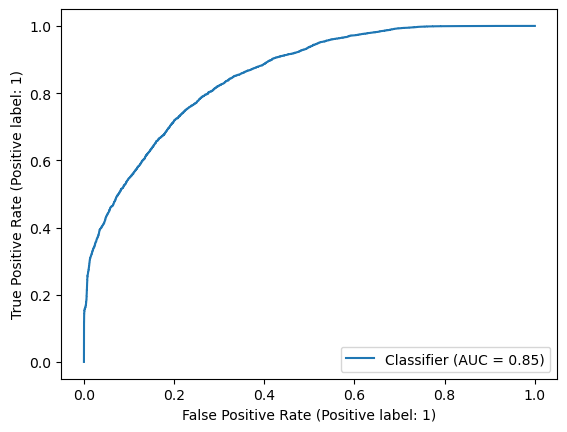

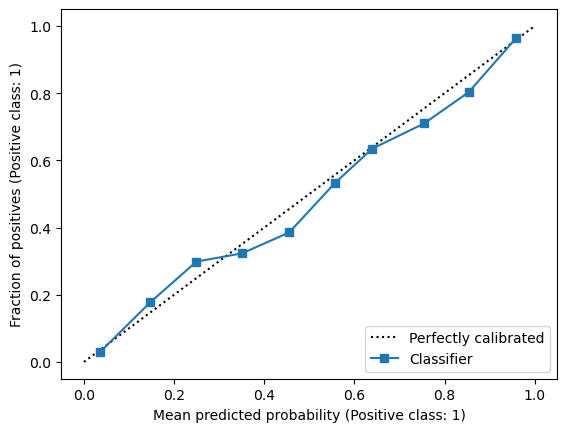

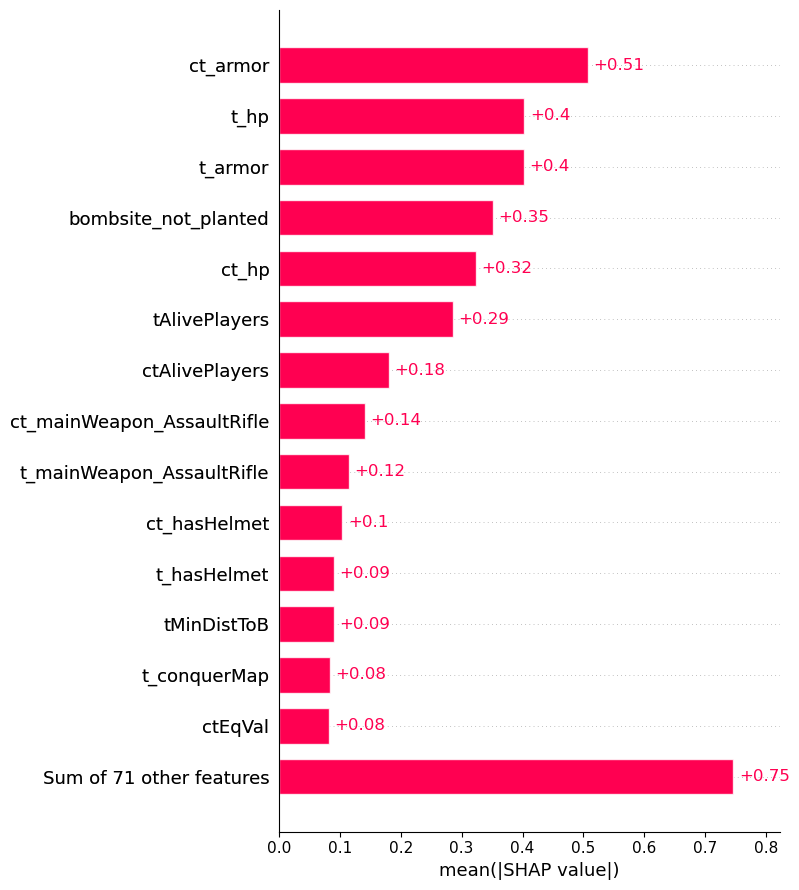

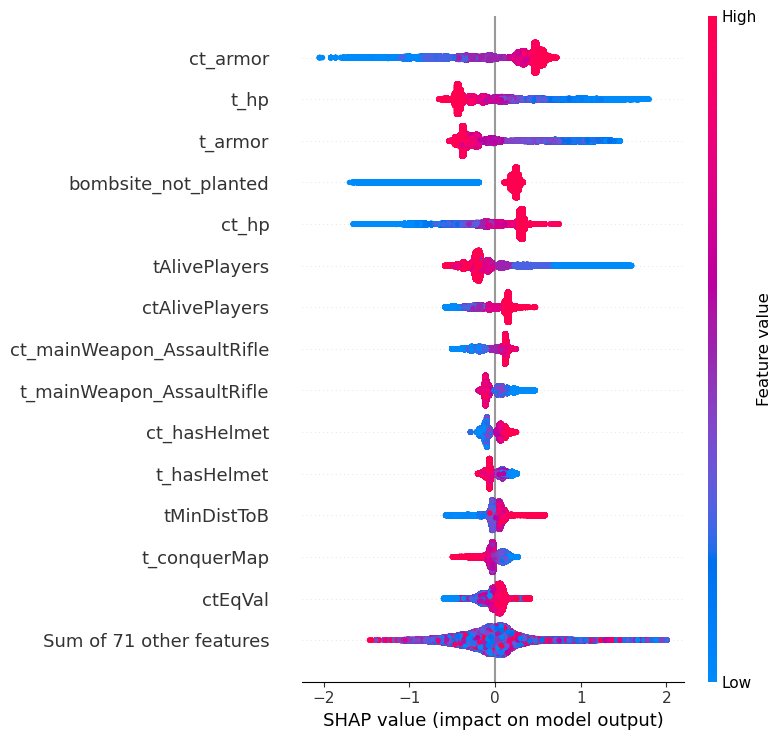

In [15]:
run_name = "LGBM with additional data v2"
additional_description = "LGBM with Bayes Optimalization"
with mlflow.start_run(run_name=run_name, description=additional_description) as run:
        mlflow.log_params(model_lgbm.get_params())
        mlflow.log_param("X_train.shape", X_train.shape)
        mlflow.log_param("X_test.shape", X_test.shape)
        mlflow.log_params({f"{key}_space": parameters[key] for key in parameters})

        y_proba = model_lgbm.predict_proba(X_test)[:, 1]
        y_true = y_test
        features_names = model_lgbm.feature_name_
        metrics = {}
        for threshold in np.arange(0.1, 1, 0.05):
            y_pred = (y_proba >= threshold).astype(int)
            metrics[f"accuracy_{threshold:.2f}"] = accuracy_score(y_true=y_true, y_pred=y_pred)
            metrics[f"precision_{threshold:.2f}"] = precision_score(y_true=y_true, y_pred=y_pred)
            metrics[f"recall_{threshold:.2f}"] = recall_score(y_true=y_true, y_pred=y_pred)
            metrics[f"f1_{threshold:.2f}"] = f1_score(y_true=y_true, y_pred=y_pred)
        metrics["roc_auc"] = roc_auc_score(y_true=y_true, y_score=y_proba)
        metrics["log_loss"] = log_loss(y_true=y_true, y_pred=y_proba)
        mlflow.log_metrics(metrics)
        
        
        os.makedirs('artifacts', exist_ok=True)
        with open("artifacts/features.txt", 'w') as f:
            f.write(str(features_names))
            
        os.makedirs('models', exist_ok=True)
        with open("models/model.pkl", "wb") as f:
            pickle.dump(model_lgbm, f)

        roc_plot = RocCurveDisplay.from_predictions(y_pred=y_proba, y_true=y_true)
        roc_plot.figure_.savefig('artifacts/roc_auc.jpg')
        plt.show()
        
        calibration_curve = CalibrationDisplay.from_predictions(y_prob=y_proba, y_true=y_true, n_bins=10)
        calibration_curve.figure_.savefig('artifacts/calibration_curve.jpg')
        plt.show()
        
        shap.plots.bar(shap_values[:, :, 1], show=False, max_display=15)
        plt.tight_layout()
        plt.savefig('artifacts/shap_importance.jpg')
        plt.show()
        
        shap.plots.beeswarm(shap_values[:, :, 1], show=False, max_display=15)
        plt.tight_layout()
        plt.savefig('artifacts/shap_beeplot.jpg')
        plt.show()
        
        mlflow.log_artifacts("artifacts", artifact_path="plots_data")
        mlflow.log_artifacts("models", artifact_path="model")